# Seq2Seq using Pytorch

This is taken from http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 


In [5]:
# imports 
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

## Preprocess
Just downloaded data to `data` dir  
1. Ran tokenizer on it.
2. Lowercased all the data


Note: Good idea to do pre processing using external tools

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
def prepareData(path, lang1, lang2, reverse=False):
    print("Reading from %s ..." % path)
    assert '%s-%s' % (lang1, lang2) in path

    # Read the file and split into lines
    lines = open('%s' % (path), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [l.split('\t') for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    #return input_lang, output_lang, pairs
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('../data/eng-fra.tok.lc.tsv', 'eng', 'fra', True)
print(random.choice(pairs))

Reading from ../data/eng-fra.tok.lc.tsv ...
Read 135842 sentence pairs
Trimmed to 135842 sentence pairs
Counting words...
Counted words:
fra 26109
eng 13572
['je ne vois aucun problème avec ça .', 'i see nothing wrong with this .']


# Seq2Seq Model

In [29]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        

In [22]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        result = result.cuda()
    return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

## Training

In [26]:
teacher_forcing_ratio = 0.5
MAX_LENGTH=100

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # For attention based decoder
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # For attention based decoder :
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [34]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    

0m 4s (- 0m 18s) (20 20%) 6.2985
0m 9s (- 0m 14s) (40 40%) 5.1482
0m 15s (- 0m 10s) (60 60%) 5.6474
0m 20s (- 0m 5s) (80 80%) 5.1875
0m 25s (- 0m 0s) (100 100%) 5.7598


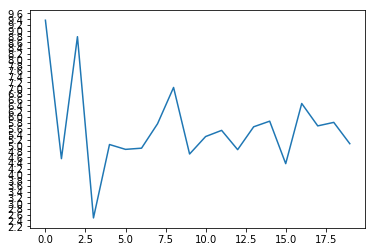

In [36]:
# Run the trainer

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)


if use_cuda:
    encoder1 = encoder1.cuda()
    decoder1 = decoder1.cuda()

trainIters(encoder1, decoder1, 100, print_every=20, plot_every=5)

0m 5s (- 0m 48s) (20 10%) 5.4907
0m 10s (- 0m 41s) (40 20%) 5.4628
0m 16s (- 0m 37s) (60 30%) 5.1292
0m 21s (- 0m 32s) (80 40%) 5.5844
0m 26s (- 0m 26s) (100 50%) 4.8052
0m 31s (- 0m 21s) (120 60%) 4.9564
0m 36s (- 0m 15s) (140 70%) 4.4205
0m 41s (- 0m 10s) (160 80%) 4.6511
0m 46s (- 0m 5s) (180 90%) 4.8218
0m 52s (- 0m 0s) (200 100%) 5.1323


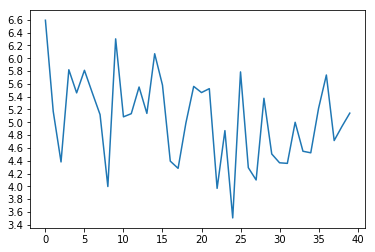

In [39]:
trainIters(encoder1, decoder1, 200, print_every=20, plot_every=5)

## Evaluate

In [37]:
# Evaluate 

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        #decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        

In [42]:
evaluateRandomly(encoder1, decoder1)

> je voudrais simplement dire que je suis désolé .
= i 'd just like to say i 'm sorry .
< i you it . <EOS>

> ferme tes yeux trois minutes .
= close your eyes for three minutes .
< i you it . <EOS>

> il a dû y aller .
= he had to go there .
< i you it . <EOS>

> je n 'ai pas pensé que tu étais chez toi .
= i didn 't think you were home .
< i you it . <EOS>

> qu 'avez-vous acheté à votre petite-amie , pour noël ?
= what have you bought your girlfriend for christmas ?
< i you it . <EOS>

> j 'y vais tous les ans .
= i go every year .
< i you it . <EOS>

> il a trois grandes sœurs .
= he has three older sisters .
< i you it . <EOS>

> je les veux vivants .
= i want them alive .
< i you it . <EOS>

> je laisse tomber . quoi que je fasse , tu sembles ne jamais être contente .
= i give up . no matter what i do , you never seem to be satisfied .
< i you it . <EOS>

> nous nous réjouissons de travailler plus étroitement avec vous à l 'avenir .
= we look forward to working more closely with y